In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


## Use Direction
Call functions in order.
1. get_data()
2. norm_data()
3. split_data()
4. input_output()
5. stacked_lstm()/bilstm()/cnn_bilstm()/attention()
6. eval(model chose)
7. convert_back() to unscaled output
8. Go to 'Based on Return'/'Based on Price' if output is return/price.


## Environment & Library Import

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from keras import regularizers, initializers, constraints
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import math
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit, train_test_split

## Get Data: get_data()

In [ ]:
# Load data from CSV file
# Enter 'ma' for method if wanting to apply moving average.
def get_data(ticker, method):
    df = pd.read_csv('/content/drive/MyDrive/FIN 550G/S&PMinute.csv') # for google drive
    # df = pd.read_csv('S&PMinute.csv') # for local
    time = pd.to_datetime(df.iloc[2:,0], errors='coerce')
    df = df.filter(regex=ticker).rename(columns=df.iloc[0]).drop(df.index[0])
    df = pd.merge(left=time, left_index=True, right=df, right_index=True, how='inner').rename(columns={'Unnamed: 0':'Time'}).set_index('Time').apply(pd.to_numeric, downcast='float', errors='coerce').iloc[:,:5]
    if method == 'rolling':
        df['volume'] = df['volume'].replace(to_replace=0, method='ffill')
        # apply 10 min moving average
        df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean()
        df = df.dropna(how='any', axis=0) 
    else:
        # Volatility: np.log(df['close']/df['close'].shift())
        df['market_impact'] = 0.5*np.log(df['close']/df['close'].shift())*(df['volume']*0.4/df['volume'])**0.5
        df = df.dropna()
    return df

In [ ]:
df = get_data('AAPL', None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

## Descriptive

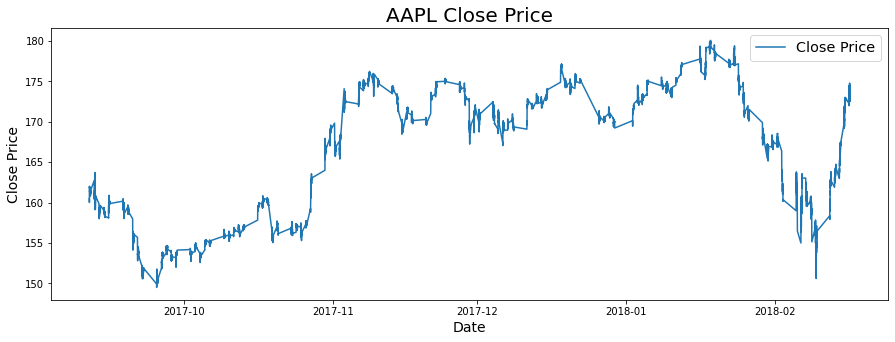

In [ ]:
# Plot minute closing price
import matplotlib as mpl
mpl.rcParams["savefig.dpi"]=1000
plt.figure(figsize=(15,5))
plt.plot(df['close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.title('AAPL Close Price', fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

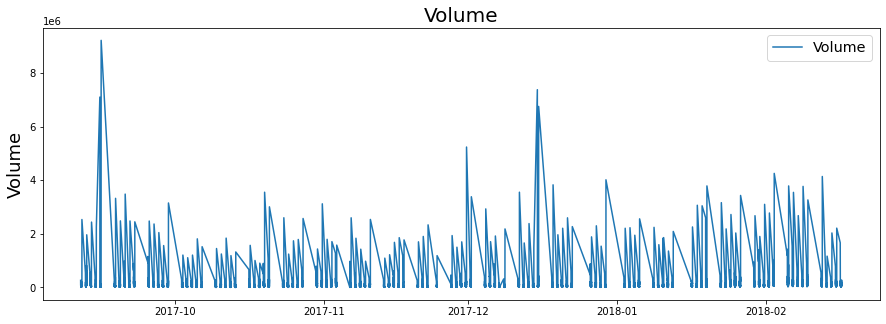

In [ ]:
# Plot minute volumes
plt.figure(figsize=(15,5))
plt.plot(df['volume'])
plt.ylabel('Volume', fontsize=18)
plt.title("Volume", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

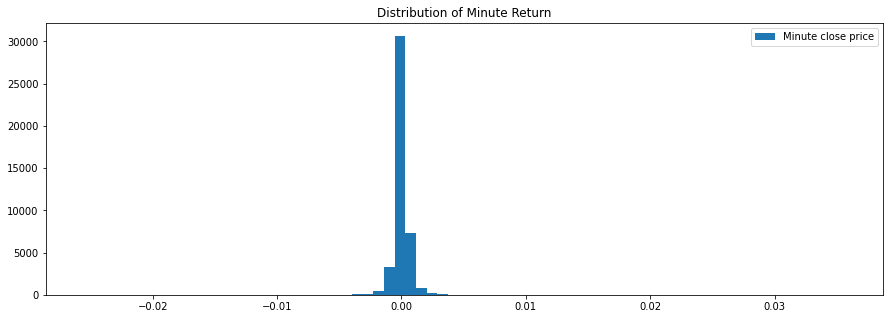

In [ ]:
# plot distribution of minute return
x = df['close']
mpl.rcParams["savefig.dpi"]=1000
plt.figure(figsize=(15,5))
returns = x.pct_change(1).dropna()
plt.hist(returns,bins="rice",label="Minute close price")
plt.title('Distribution of Minute Return')
plt.legend()
plt.show()

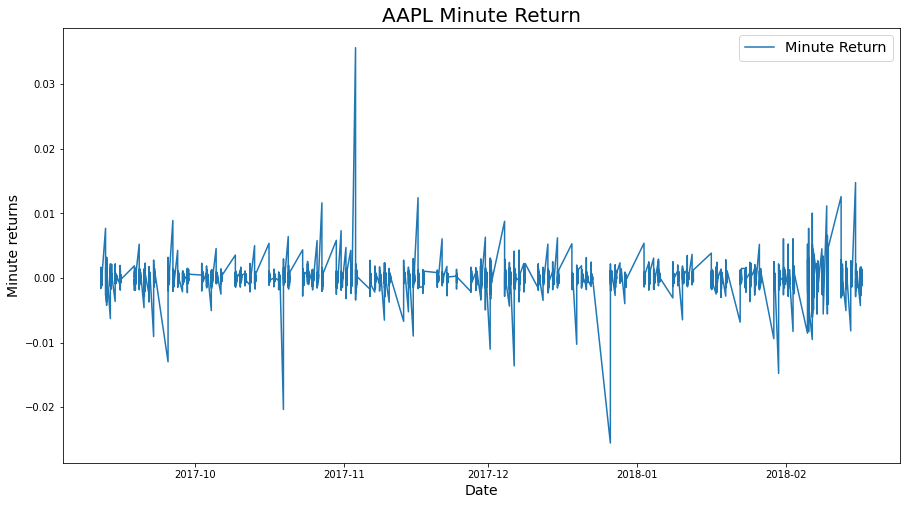

In [ ]:
# Plot Minute Return
plt.rcParams["savefig.dpi"]=1000
plt.figure(figsize=(15,8))
plt.plot(returns)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Minute returns", fontsize=14)
plt.title('AAPL Minute Return', fontsize=20)
plt.legend(['Minute Return'], fontsize='x-large', loc='best')
plt.show()

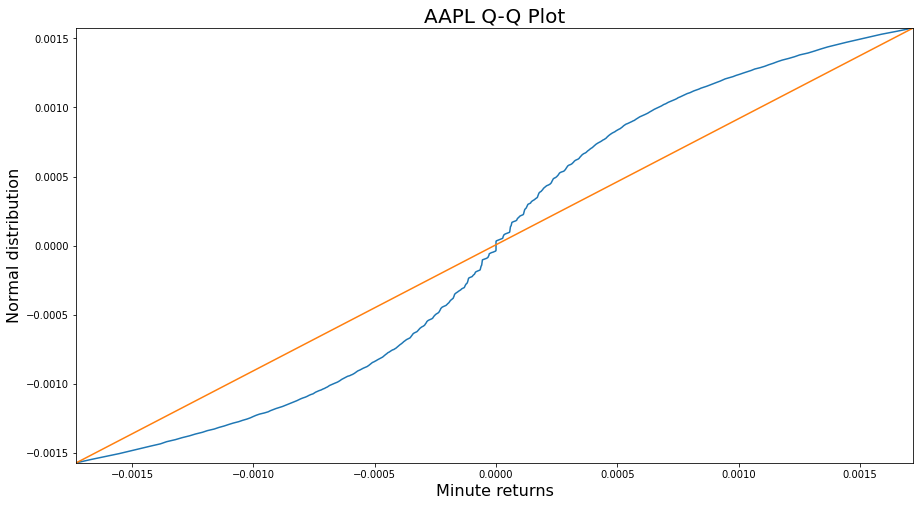

In [ ]:
# Q-Q Plot to check normal distribution
from scipy.stats import skew,kurtosis,norm,skewtest,kurtosistest
t = np.linspace(0.01,0.99,1000)
plt.figure(figsize=(15,8))
q1 = np.quantile(returns,t)
q2 = norm.ppf(t,loc=np.mean(returns),scale=np.std(returns))
plt.plot(q1,q2)
plt.plot([min(q1),max(q1)],[min(q2),max(q2)])
plt.xlim((min(q1),max(q1)))
plt.ylim((min(q2),max(q2)))
plt.xlabel("Minute returns", fontsize=16)
plt.ylabel("Normal distribution", fontsize=16)
plt.title('AAPL Q-Q Plot', fontsize=20)
plt.show()

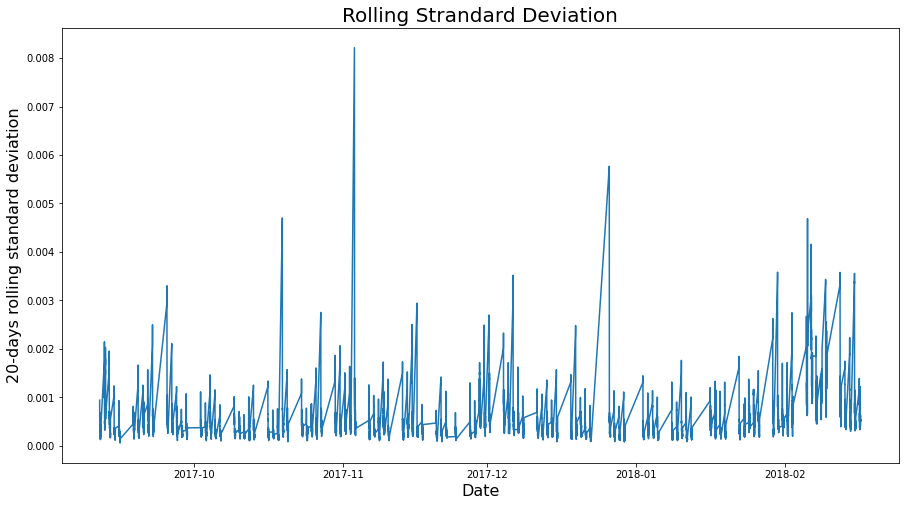

In [ ]:
# Rolling SD
plt.rcParams["savefig.dpi"]=1000
plt.figure(figsize=(15,8))
plt.plot(returns.rolling(20).std())
plt.xlabel("Date", fontsize=16)
plt.ylabel("20-days rolling standard deviation", fontsize=16)
plt.title('Rolling Strandard Deviation', fontsize=20)
plt.show()

## Preprocessing: norm_data()

In [ ]:
def create_feature(data, feature, rolling_window, a):
    # create new features
    data['sma'] = data[feature].rolling(rolling_window).mean()
    data['minute_return'] = data[feature]/data[feature].shift() - 1
    data['min_bollinger_band'] = data[feature].rolling(rolling_window).mean() - 2 * data[feature].std()
    data['max_bollinger_band'] = data[feature].rolling(rolling_window).mean() + 2 * data[feature].std()
    data['ema'] = data[feature].ewm(alpha=a).mean()
    return data

In [ ]:
# Normalizezd percentage change
def norm_data(df, method):
    norm_data.df = pd.DataFrame()
    for col in df.columns[[3,4,6,7,8,9,10]]:
        if method == 'return': # if target variable is minute return
            norm_data.df[col] = df[col].pct_change()
        else: # if target vairable is close price
            norm_data.df[col] = df[col]
    norm_data.df.dropna(how='any', axis=0, inplace=True)

    # Scale dataset using min-max normalization
    scaler = MinMaxScaler()
    norm_df = norm_data.df[:]
    norm_df[norm_df.columns] = scaler.fit_transform(norm_df[norm_df.columns])
    return norm_df

In [ ]:
df = create_feature(df, 'close', 10, 0.5)
norm_df = norm_data(df, None)

In [ ]:
norm_df.head()

,close,volume,sma,minute_return,min_bollinger_band,max_bollinger_band,ema
Time,,,,,,,
2017-09-11 09:40:00,0.368868,0.021752,0.350474,0.420793,0.350474,0.350474,0.359982
2017-09-11 09:41:00,0.369523,0.011094,0.351435,0.419563,0.351435,0.351435,0.361872
2017-09-11 09:42:00,0.369195,0.021943,0.352992,0.416512,0.352992,0.352992,0.362650
2017-09-11 09:43:00,0.377371,0.023347,0.355941,0.442946,0.355941,0.355941,0.367172
2017-09-11 09:44:00,0.377044,0.019597,0.358426,0.416515,0.358426,0.358426,0.369267


## Split data: split_data()

In [ ]:
# Split train, test
def split_data(df):
    length = len(df.index)
    val_split = df.index[-int(0.2*length)] # First 80% train
    test_split = df.index[-int(0.1*length)] # last 10% test
    split_data.df_train = df[:val_split]
    split_data.df_val = df[val_split:test_split]
    split_data.df_test = df[test_split:]

    train_data = split_data.df_train.values
    val_data = split_data.df_val.values
    test_data = split_data.df_test.values
    return train_data, val_data, test_data

In [ ]:
# Split scaled data
train_data, val_data, test_data = split_data(norm_df)

# Split unscaled data
unscaled_train, unscaled_val, unscaled_test = split_data(norm_data.df)

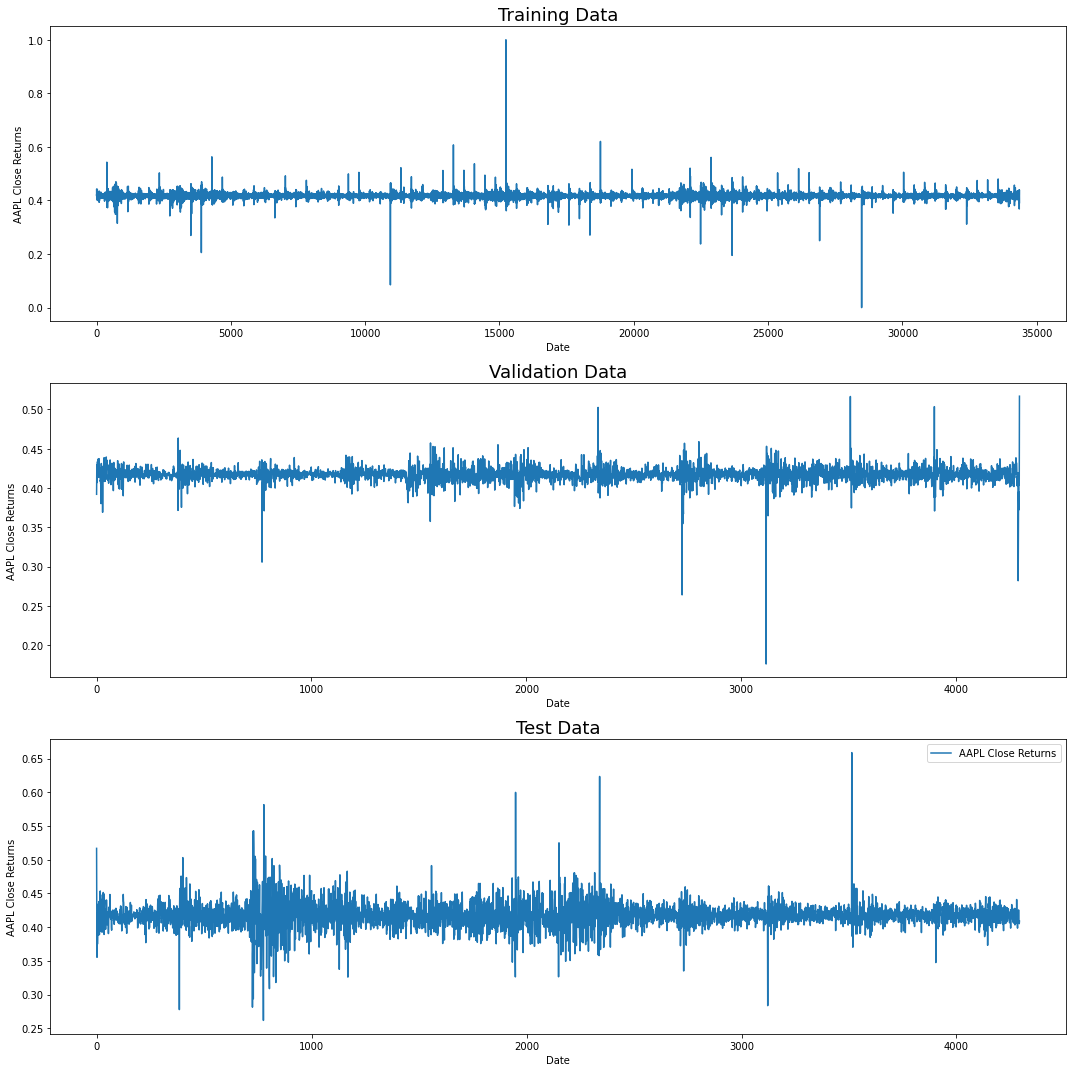

In [ ]:
# Visualize results
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("", fontsize=22)
st.set_y(1.02)

# Training results
sub_1 = fig.add_subplot(311)
sub_1.plot(train_data[:, 3], label='AAPL Close Returns')
sub_1.set_title('Training Data', fontsize=18)
sub_1.set_xlabel('Date')
sub_1.set_ylabel('AAPL Close Returns')

# Validation results
sub_2 = fig.add_subplot(312)
sub_2.plot(val_data[:, 3], label='AAPL Close Returns')
sub_2.set_title('Validation Data', fontsize=18)
sub_2.set_xlabel('Date')
sub_2.set_ylabel('AAPL Close Returns')

# Test results
sub_3 = fig.add_subplot(313)
sub_3.plot(test_data[:, 3], label='AAPL Close Returns')
sub_3.set_title('Test Data', fontsize=18)
sub_3.set_xlabel('Date')
sub_3.set_ylabel('AAPL Close Returns')

plt.tight_layout()
plt.legend(loc='best')

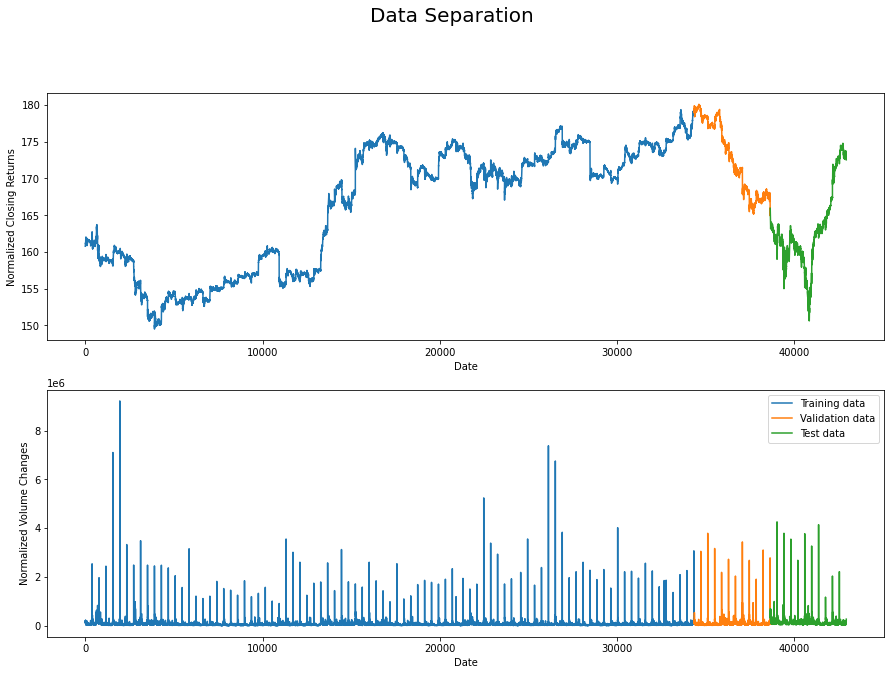

In [ ]:
# Plot daily changes
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(1)

# close
sub1 = fig.add_subplot(211)
sub1.plot(np.arange(train_data.shape[0]), split_data.df_train['close'], label='Training data')
sub1.plot(np.arange(train_data.shape[0],
         train_data.shape[0]+val_data.shape[0]), split_data.df_val['close'], label='Validation data')
sub1.plot(np.arange(train_data.shape[0]+val_data.shape[0],
         train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), split_data.df_test['close'], label='Test data')
sub1.set_xlabel('Date')
sub1.set_ylabel('Normalized Closing Returns')

# volume
sub2 = fig.add_subplot(212)
sub2.plot(np.arange(train_data.shape[0]), split_data.df_train['volume'], label='Training data')
sub2.plot(np.arange(train_data.shape[0],
         train_data.shape[0]+val_data.shape[0]), split_data.df_val['volume'], label='Validation data')
sub2.plot(np.arange(train_data.shape[0]+val_data.shape[0],
         train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), split_data.df_test['volume'], label='Test data')
sub2.set_xlabel('Date')
sub2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

## Create input chunks and output: input_output()

In [ ]:
# Create input chunks based on window

def input_output(train_data, val_data, test_data, window):
    # Training
    x_train,y_train=[],[]
    for i in range(window,len(train_data)):
        x_train.append(train_data[i-window:i])
        y_train.append(train_data[:,3][i])
    
    x_train,y_train=np.array(x_train),np.array(y_train)

    # Validation
    x_val,y_val=[],[]
    for i in range(window,len(val_data)):
        x_val.append(val_data[i-window:i])
        y_val.append(val_data[:,3][i])
    
    x_val,y_val=np.array(x_val),np.array(y_val)

    # Test
    x_test,y_test=[],[]
    for i in range(window,len(test_data)):
        x_test.append(test_data[i-window:i])
        y_test.append(test_data[:,3][i])

    x_test, y_test=np.array(x_test),np.array(y_test)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
# Create previous 180 historical data as input
x_train, y_train, x_val, y_val, x_test, y_test = input_output(train_data, val_data, test_data, 180)

# Models

## Fit, predict and evaluate functions

In [ ]:
def eval(model):
    # Fit
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, 
          verbose=1, mode='auto', restore_best_weights=True)
    model.fit(x_train,y_train,validation_data=(x_val,y_val),
          callbacks=[monitor],verbose=1,epochs=10)
  
    # Predict
    eval.train_pred = model.predict(x_train)
    eval.val_pred = model.predict(x_val)
    eval.test_pred = model.predict(x_test)

    # Evaluate
    train_eval = model.evaluate(x_train, y_train, verbose=1)
    val_eval = model.evaluate(x_val, y_val, verbose=1)
    test_eval = model.evaluate(x_test, y_test, verbose=1)

    print('Evaluation metrics')
    print('Training Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
    print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
    print('Test Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

In [ ]:
def convert_back(target, original, pred, output):
    scaler = MinMaxScaler()
    if output == 'return': # enter return if output is minute return
        target_scaler = scaler.fit_transform(pd.DataFrame(df[target].pct_change()[1:]).values)
    else: # enter None if output is close price
        target_scaler = scaler.fit_transform(pd.DataFrame(df[target][1:]).values)
    prediction = scaler.inverse_transform(pred)
    convert_back.unscaled_y_test = scaler.inverse_transform(original.reshape(-1, 1))
    return prediction

In [ ]:
def rmse(pred, original):
    rmse=np.sqrt(np.mean(pred-original)**2)
    return rmse

## Stacked LSTM: stacked_lstm()

In [ ]:
# Train model
def stacked_lstm():
    model = Sequential()
    model.add(BatchNormalization())
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error', 
                metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

In [ ]:
eval(stacked_lstm())

Epoch 1/10
1069/1069 [==============================] - 23s 19ms/step - loss: 0.0030 - mae: 0.0144 - rmse: 0.0545 - val_loss: 1.1413e-04 - val_mae: 0.0064 - val_rmse: 0.0107
Epoch 2/10
1069/1069 [==============================] - 19s 18ms/step - loss: 1.0100e-04 - mae: 0.0058 - rmse: 0.0100 - val_loss: 1.1142e-04 - val_mae: 0.0062 - val_rmse: 0.0106
Epoch 3/10
1069/1069 [==============================] - 19s 18ms/step - loss: 1.0272e-04 - mae: 0.0060 - rmse: 0.0101 - val_loss: 1.5373e-04 - val_mae: 0.0089 - val_rmse: 0.0124
Epoch 4/10
1069/1069 [==============================] - 20s 18ms/step - loss: 1.0293e-04 - mae: 0.0060 - rmse: 0.0101 - val_loss: 1.8171e-04 - val_mae: 0.0100 - val_rmse: 0.0135
Epoch 00004: early stopping
129/129 [==============================] - 1s 8ms/step - loss: 4.0104e-04 - mae: 0.0133 - rmse: 0.0200
Evaluation metrics
Training Data - Loss: 0.0001, MAE: 0.0059, RMSE: 0.0101
Validation Data - Loss: 0.0001, MAE: 0.0064, RMSE: 0.0107
Test Data - Loss: 0.0004, MA

In [ ]:
predicted_return = convert_back('close', y_test, eval.test_pred)

In [ ]:
eval(stacked_lstm())
predicted_return = convert_back('close', y_test, eval.test_pred)
convert_back('close',y_train, eval.train_pred)
# Visualize results
plt.rcParams["savefig.dpi"]=1000
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("LSTM Model", fontsize=22)
st.set_y(1.02)

# Training results
sub_1 = fig.add_subplot(311)
sub_1.plot(unscaled_train[:, 0], label='AAPL Close Returns')
sub_1.plot(convert_back('close',y_train, eval.train_pred), color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_1.set_title('Training Data', fontsize=18)
sub_1.set_xlabel('Date')
sub_1.set_ylabel('AAPL Close Returns')

# Validation results
sub_2 = fig.add_subplot(312)
sub_2.plot(unscaled_val[:, 0], label='AAPL Close Returns')
sub_2.plot(convert_back('close',y_val, eval.val_pred), color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_2.set_title('Validation Data', fontsize=18)
sub_2.set_xlabel('Date')
sub_2.set_ylabel('AAPL Close Returns')

# Test results
sub_3 = fig.add_subplot(313)
sub_3.plot(unscaled_test[:, 0], label='AAPL Close Returns')
sub_3.plot(predicted_return, color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_3.set_title('Test Data', fontsize=18)
sub_3.set_xlabel('Date')
sub_3.set_ylabel('AAPL Close Returns')

plt.tight_layout()
plt.legend(loc='best')

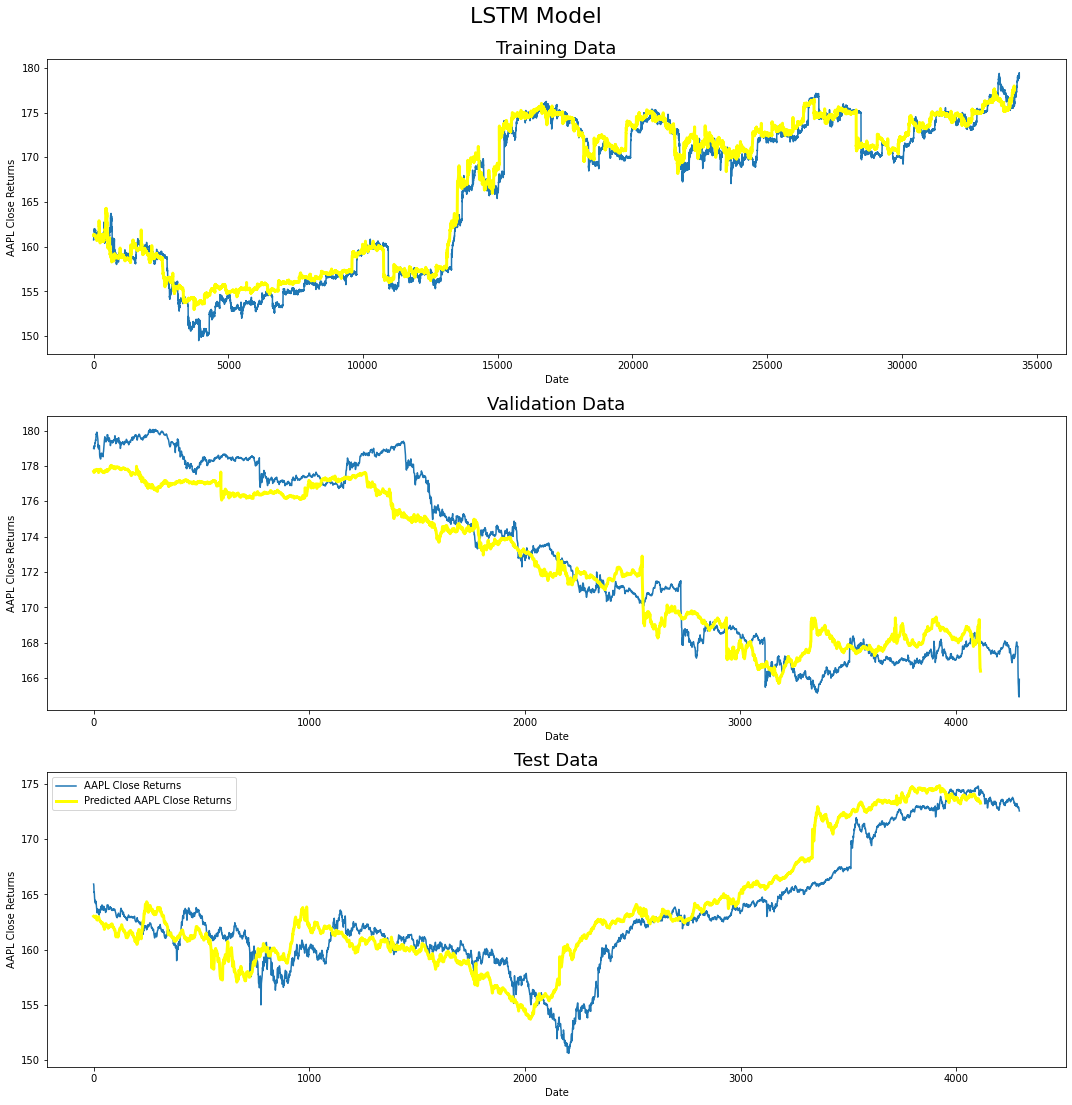

In [ ]:
#@title
# Visualize results
plt.rcParams["savefig.dpi"]=1000
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("LSTM Model", fontsize=22)
st.set_y(1.02)

# Training results
sub_1 = fig.add_subplot(311)
sub_1.plot(unscaled_train[:, 0], label='AAPL Close Returns')
sub_1.plot(convert_back('close',y_train, eval.train_pred), color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_1.set_title('Training Data', fontsize=18)
sub_1.set_xlabel('Date')
sub_1.set_ylabel('AAPL Close Returns')

# Validation results
sub_2 = fig.add_subplot(312)
sub_2.plot(unscaled_val[:, 0], label='AAPL Close Returns')
sub_2.plot(convert_back('close',y_val, eval.val_pred), color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_2.set_title('Validation Data', fontsize=18)
sub_2.set_xlabel('Date')
sub_2.set_ylabel('AAPL Close Returns')

# Test results
sub_3 = fig.add_subplot(313)
sub_3.plot(unscaled_test[:, 0], label='AAPL Close Returns')
sub_3.plot(predicted_return, color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_3.set_title('Test Data', fontsize=18)
sub_3.set_xlabel('Date')
sub_3.set_ylabel('AAPL Close Returns')

plt.tight_layout()
plt.legend(loc='best')

## Bi-LSTM: bilstm()

In [ ]:
# Train model
def stacked_lstm():
  model = Sequential()
  model.add(BatchNormalization())  
  model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]))))
  model.add(Bidirectional(LSTM(100, return_sequences=False)))
  model.add(Dense(32))
  model.add(Dense(1, activation='relu'))

  model.compile(optimizer='adam', loss='mean_squared_error', 
                metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
  return model

In [ ]:
eval(stacked_lstm())

Epoch 1/10
1069/1069 [==============================] - 47s 39ms/step - loss: 0.0050 - mae: 0.0199 - rmse: 0.0705 - val_loss: 1.2245e-04 - val_mae: 0.0068 - val_rmse: 0.0111
Epoch 2/10
1069/1069 [==============================] - 40s 37ms/step - loss: 1.2873e-04 - mae: 0.0070 - rmse: 0.0113 - val_loss: 1.9255e-04 - val_mae: 0.0105 - val_rmse: 0.0139
Epoch 3/10
1069/1069 [==============================] - 40s 38ms/step - loss: 1.2016e-04 - mae: 0.0068 - rmse: 0.0110 - val_loss: 2.5050e-04 - val_mae: 0.0122 - val_rmse: 0.0158
Epoch 4/10
1069/1069 [==============================] - 40s 37ms/step - loss: 1.1515e-04 - mae: 0.0066 - rmse: 0.0107 - val_loss: 2.3683e-04 - val_mae: 0.0121 - val_rmse: 0.0154
Epoch 00004: early stopping
129/129 [==============================] - 2s 15ms/step - loss: 4.4943e-04 - mae: 0.0144 - rmse: 0.0212
Evaluation metrics
Training Data - Loss: 0.0001, MAE: 0.0060, RMSE: 0.0103
Validation Data - Loss: 0.0001, MAE: 0.0068, RMSE: 0.0111
Test Data - Loss: 0.0004, M

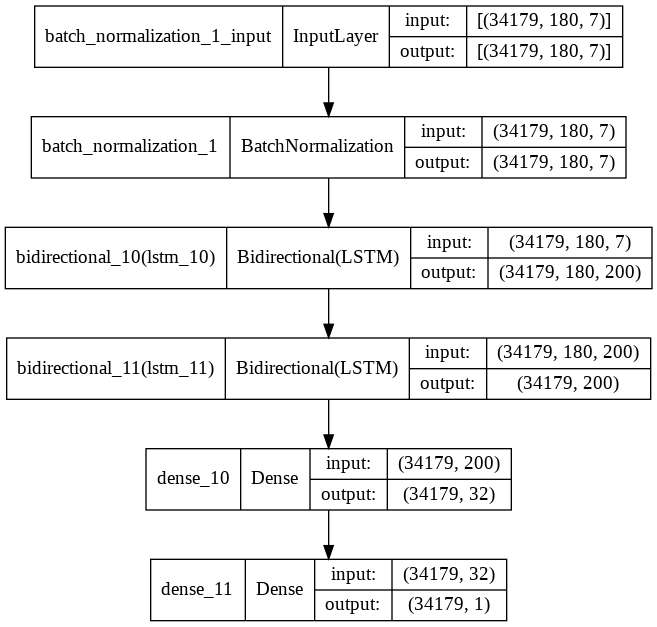

In [ ]:
from keras.utils.vis_utils import plot_model
model = stacked_lstm()
model.build(x_train.shape)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
predicted_return = convert_back('close', y_test, eval.test_pred)

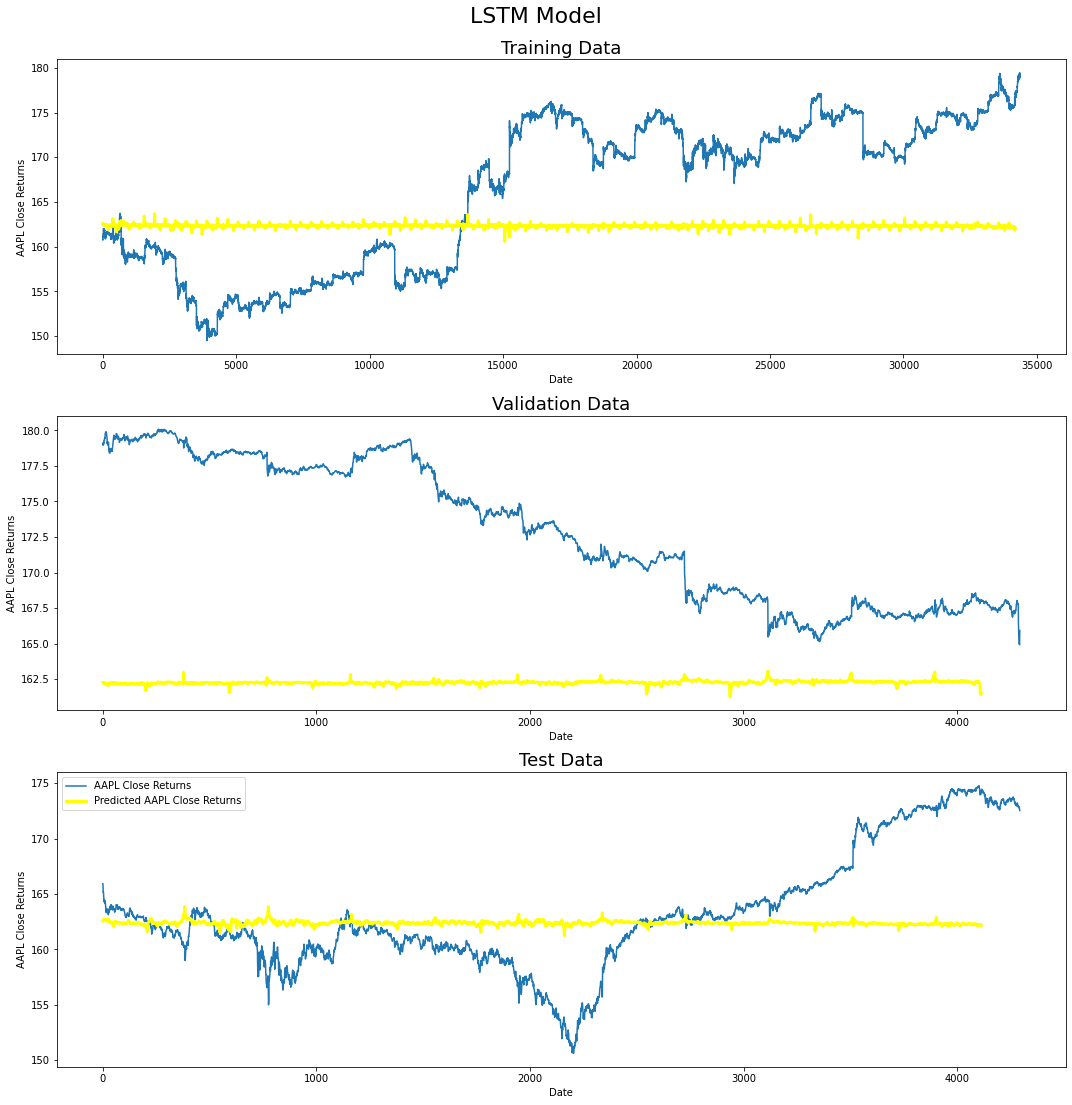

In [ ]:
# Visualize results
plt.rcParams["savefig.dpi"]=1000
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("LSTM Model", fontsize=22)
st.set_y(1.02)

# Training results
sub_1 = fig.add_subplot(311)
sub_1.plot(unscaled_train[:, 0], label='AAPL Close Returns')
sub_1.plot(convert_back('close',y_train, eval.train_pred), color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_1.set_title('Training Data', fontsize=18)
sub_1.set_xlabel('Date')
sub_1.set_ylabel('AAPL Close Returns')

# Validation results
sub_2 = fig.add_subplot(312)
sub_2.plot(unscaled_val[:, 0], label='AAPL Close Returns')
sub_2.plot(convert_back('close',y_val, eval.val_pred), color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_2.set_title('Validation Data', fontsize=18)
sub_2.set_xlabel('Date')
sub_2.set_ylabel('AAPL Close Returns')

# Test results
sub_3 = fig.add_subplot(313)
sub_3.plot(unscaled_test[:, 0], label='AAPL Close Returns')
sub_3.plot(predicted_return, color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_3.set_title('Test Data', fontsize=18)
sub_3.set_xlabel('Date')
sub_3.set_ylabel('AAPL Close Returns')

plt.tight_layout()
plt.legend(loc='best')

## CNN + Bi-LSTM: cnn_bilstm()

In [ ]:
# Train model
def cnn_lstm():
  model = Sequential()
  model.add(Conv1D(64,1,activation="relu", input_shape=(x_train.shape[1],x_train.shape[2])))
  model.add(MaxPooling1D(1))
  model.add(Bidirectional(LSTM(100, return_sequences=True)))
  model.add(Bidirectional(LSTM(100, return_sequences=False)))
  model.add(Dense(32))
  model.add(Dense(1, activation='relu'))

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
  return model

In [ ]:
eval(cnn_lstm())

Epoch 1/10
1069/1069 [==============================] - 47s 39ms/step - loss: 6.8770e-04 - mae: 0.0090 - rmse: 0.0262 - val_loss: 1.2788e-04 - val_mae: 0.0072 - val_rmse: 0.0113
Epoch 2/10
1069/1069 [==============================] - 40s 38ms/step - loss: 1.0656e-04 - mae: 0.0062 - rmse: 0.0103 - val_loss: 1.1364e-04 - val_mae: 0.0064 - val_rmse: 0.0107
Epoch 3/10
1069/1069 [==============================] - 40s 37ms/step - loss: 1.0507e-04 - mae: 0.0061 - rmse: 0.0103 - val_loss: 1.3131e-04 - val_mae: 0.0074 - val_rmse: 0.0115
Epoch 4/10
1069/1069 [==============================] - 40s 37ms/step - loss: 1.0281e-04 - mae: 0.0059 - rmse: 0.0101 - val_loss: 1.1682e-04 - val_mae: 0.0067 - val_rmse: 0.0108
Epoch 00004: early stopping
129/129 [==============================] - 2s 15ms/step - loss: 4.0388e-04 - mae: 0.0135 - rmse: 0.0201
Evaluation metrics
Training Data - Loss: 0.0001, MAE: 0.0062, RMSE: 0.0102
Validation Data - Loss: 0.0001, MAE: 0.0072, RMSE: 0.0113
Test Data - Loss: 0.000

In [ ]:
predicted_return = convert_back('close', y_test, eval.test_pred)

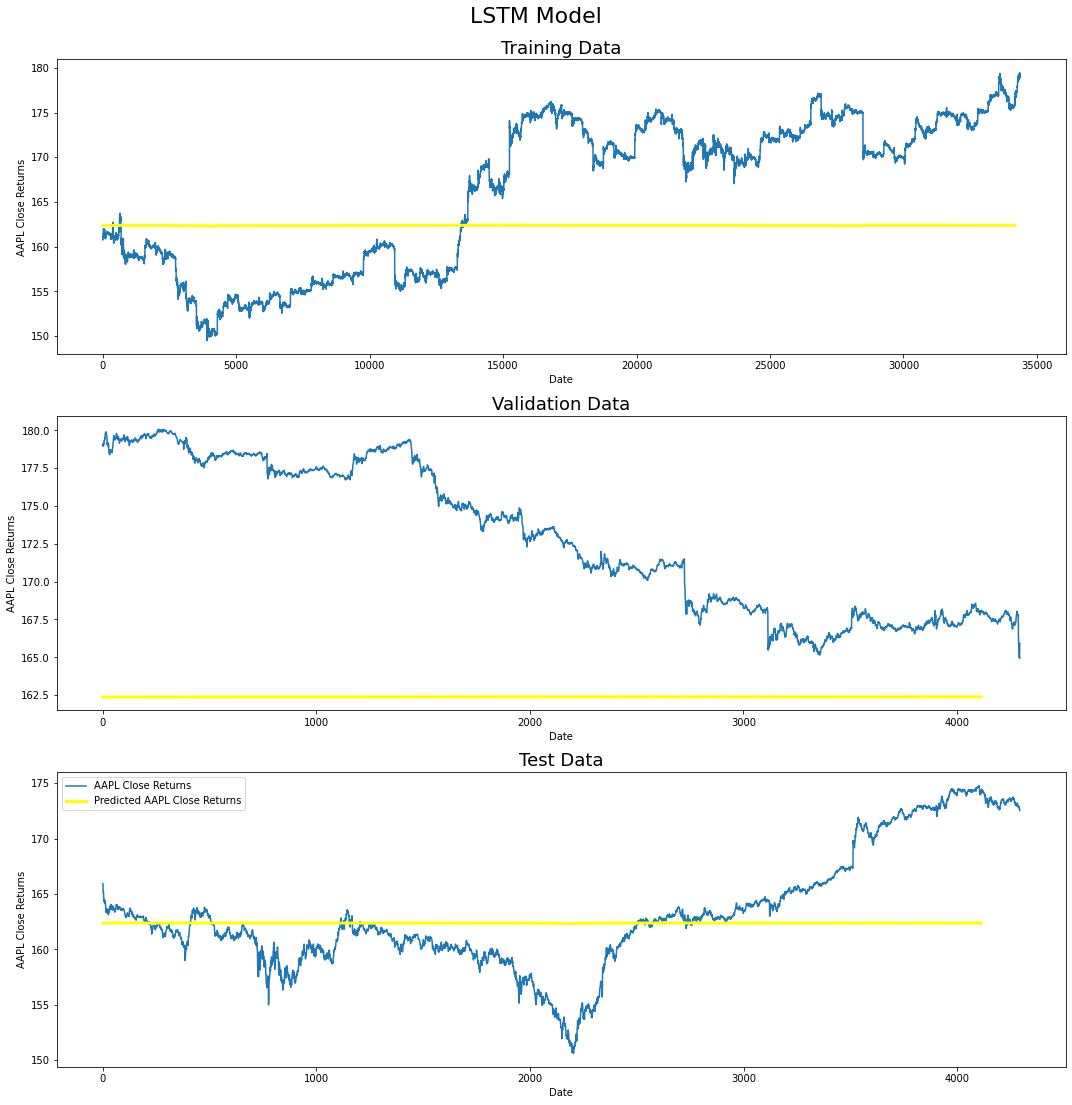

In [ ]:
# Visualize results
plt.rcParams["savefig.dpi"]=1000
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("LSTM Model", fontsize=22)
st.set_y(1.02)

# Training results
sub_1 = fig.add_subplot(311)
sub_1.plot(unscaled_train[:, 0], label='AAPL Close Returns')
sub_1.plot(convert_back('close',y_train, eval.train_pred), color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_1.set_title('Training Data', fontsize=18)
sub_1.set_xlabel('Date')
sub_1.set_ylabel('AAPL Close Returns')

# Validation results
sub_2 = fig.add_subplot(312)
sub_2.plot(unscaled_val[:, 0], label='AAPL Close Returns')
sub_2.plot(convert_back('close',y_val, eval.val_pred), color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_2.set_title('Validation Data', fontsize=18)
sub_2.set_xlabel('Date')
sub_2.set_ylabel('AAPL Close Returns')

# Test results
sub_3 = fig.add_subplot(313)
sub_3.plot(unscaled_test[:, 0], label='AAPL Close Returns')
sub_3.plot(predicted_return, color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_3.set_title('Test Data', fontsize=18)
sub_3.set_xlabel('Date')
sub_3.set_ylabel('AAPL Close Returns')

plt.tight_layout()
plt.legend(loc='best')

## Attention Mechanism: attnetion()

In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1)
    return tf.concat([time_linear, time_periodic], axis=-1)
   
  def get_config(self): # if needed for saving and loading model
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs):
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  

    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')

    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape)    
  
  def call(self, inputs): 
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # if needed for saving and loading model
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [ ]:
# Train model
def attention():
  time_embedding = Time2Vector(180)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(x_train.shape[1], x_train.shape[2]))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
  return model

In [ ]:
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

eval(attention())

Epoch 1/10
1069/1069 [==============================] - 421s 374ms/step - loss: 0.0022 - mae: 0.0265 - rmse: 0.0464 - val_loss: 1.3357e-04 - val_mae: 0.0077 - val_rmse: 0.0116
Epoch 2/10
1069/1069 [==============================] - 394s 368ms/step - loss: 5.3788e-04 - mae: 0.0179 - rmse: 0.0232 - val_loss: 1.1372e-04 - val_mae: 0.0064 - val_rmse: 0.0107
Epoch 3/10
1069/1069 [==============================] - 392s 366ms/step - loss: 3.3366e-04 - mae: 0.0138 - rmse: 0.0183 - val_loss: 1.2614e-04 - val_mae: 0.0073 - val_rmse: 0.0112
Epoch 4/10
1069/1069 [==============================] - 391s 366ms/step - loss: 1.9663e-04 - mae: 0.0100 - rmse: 0.0140 - val_loss: 1.1486e-04 - val_mae: 0.0064 - val_rmse: 0.0107
Epoch 00004: early stopping
129/129 [==============================] - 16s 126ms/step - loss: 4.1942e-04 - mae: 0.0138 - rmse: 0.0205
Evaluation metrics
Training Data - Loss: 0.0001, MAE: 0.0071, RMSE: 0.0108
Validation Data - Loss: 0.0001, MAE: 0.0077, RMSE: 0.0116
Test Data - Loss:

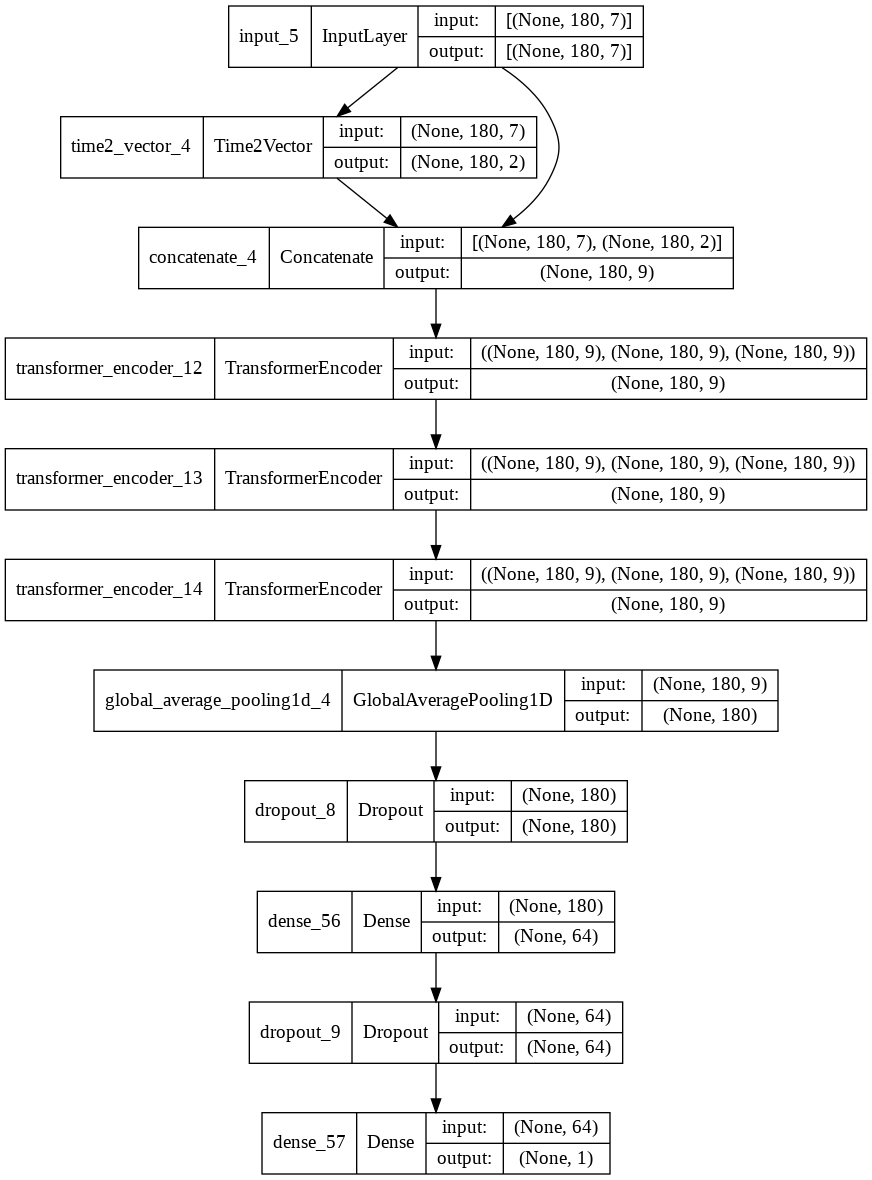

In [ ]:
from keras.utils.vis_utils import plot_model

# Visualize model structure
model = attention()
model.build(x_train.shape)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
predicted_return = convert_back('close', y_test, eval.test_pred)

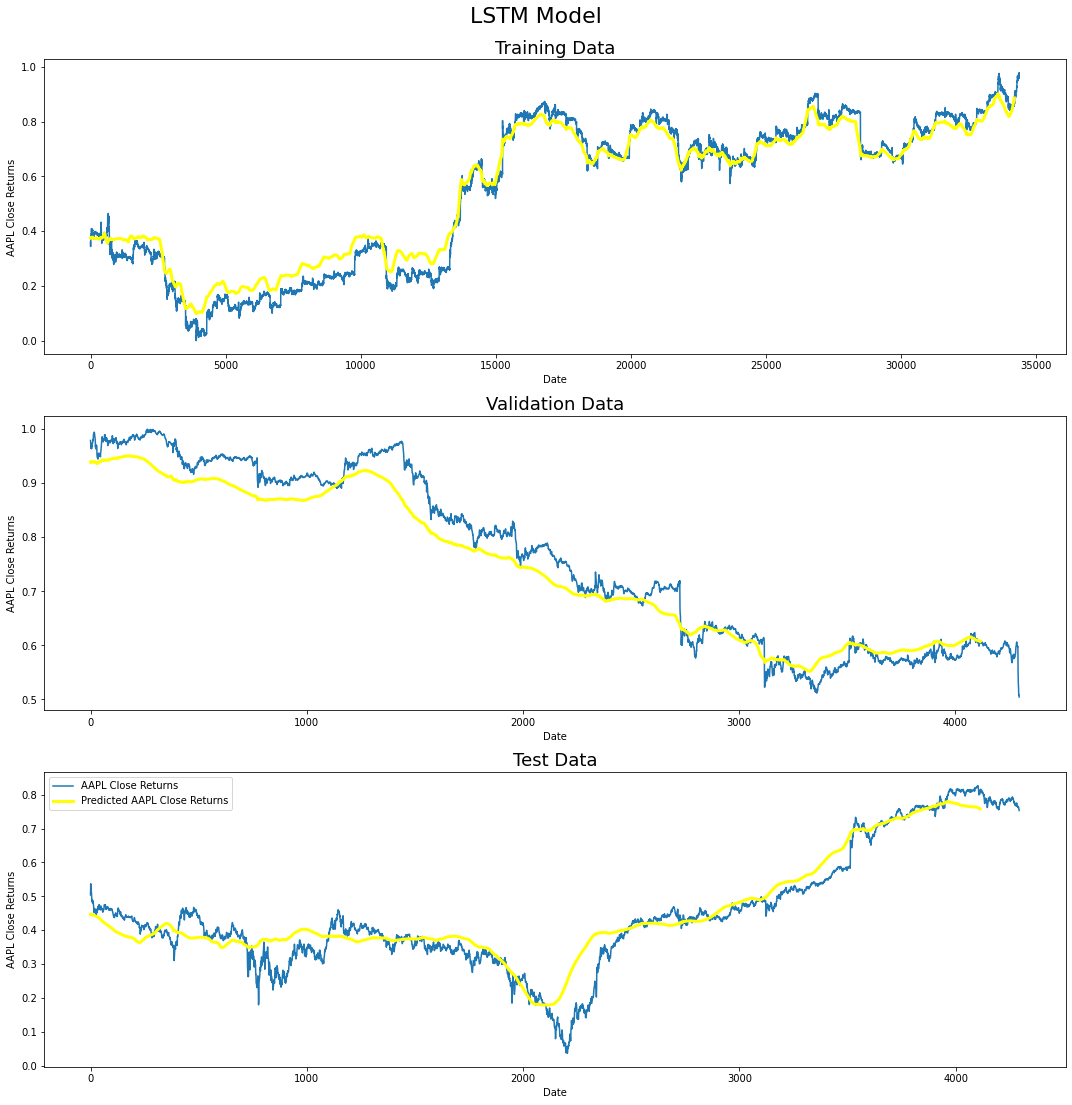

In [ ]:
#@title
# Visualize results
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Attention Model", fontsize=22)
st.set_y(1.02)

# Training results
sub_1 = fig.add_subplot(311)
sub_1.plot(train_data[:, 3], label='AAPL Close Returns')
sub_1.plot(eval.train_pred, color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_1.set_title('Training Data', fontsize=18)
sub_1.set_xlabel('Date')
sub_1.set_ylabel('AAPL Close Returns')

# Validation results
sub_2 = fig.add_subplot(312)
sub_2.plot(val_data[:, 3], label='AAPL Close Returns')
sub_2.plot(eval.val_pred, color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_2.set_title('Validation Data', fontsize=18)
sub_2.set_xlabel('Date')
sub_2.set_ylabel('AAPL Close Returns')

# Test results
sub_3 = fig.add_subplot(313)
sub_3.plot(test_data[:, 3], label='AAPL Close Returns')
sub_3.plot(eval.test_pred, color='yellow', linewidth=3, label='Predicted AAPL Close Returns')
sub_3.set_title('Test Data', fontsize=18)
sub_3.set_xlabel('Date')
sub_3.set_ylabel('AAPL Close Returns')

plt.tight_layout()
plt.legend(loc='best')

# Trading Strategy

### Based on Return

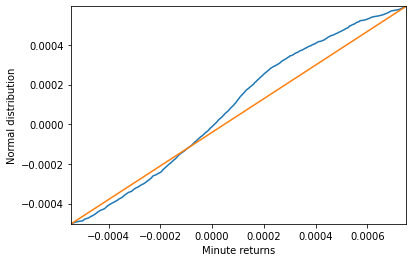

In [ ]:
from scipy.stats import skew,kurtosis,norm,skewtest,kurtosistest
t = np.linspace(0.01,0.99,1000)
q1 = np.quantile(predicted_return,t)
q2 = norm.ppf(t,loc=np.mean(predicted_return),scale=np.std(predicted_return))
plt.plot(q1,q2)
plt.plot([min(q1),max(q1)],[min(q2),max(q2)])
plt.xlim((min(q1),max(q1)))
plt.ylim((min(q2),max(q2)))
plt.xlabel("Minute returns")
plt.ylabel("Normal distribution")
plt.title('')
plt.show()

In [ ]:
predicted_return.shape

(4112, 1)

In [ ]:
# This should be modified based on shape of predicted_return
open = df['open'].iloc[(-1)*len(predicted_return)-1:-1]
close = df['close'].iloc[(-1)*len(predicted_return)-1:-1]

(4112,)

In [ ]:
buy_price = []
sell_price = []
return_signal = []
signal = 0

signals = pd.DataFrame(index=open.index)
signals.index = pd.to_datetime(signals.index)
signals['signal'] = 0
signals['returns'] = convert_back.unscaled_y_test
signals['signal'] = np.where(predicted_return>0,1,-1) 
signals['strategy_return'] = signals['signal']*signals['returns']

In [ ]:
signals

,signal,returns,strategy_return
Time,,,
2018-02-02 12:37:00,1,-0.000005,-0.000005
2018-02-02 12:38:00,1,-0.000055,-0.000055
2018-02-02 12:39:00,1,-0.000062,-0.000062
2018-02-02 12:40:00,1,-0.000064,-0.000064
2018-02-02 12:41:00,1,-0.000063,-0.000063
...,...,...,...
2018-02-16 15:54:00,-1,-0.000029,0.000029
2018-02-16 15:55:00,-1,-0.000184,0.000184
2018-02-16 15:56:00,-1,-0.000243,0.000243


In [ ]:
signals[['returns', 'strategy_return']].sum().apply(np.exp)

returns            1.060845
strategy_return    2.285088
dtype: float64

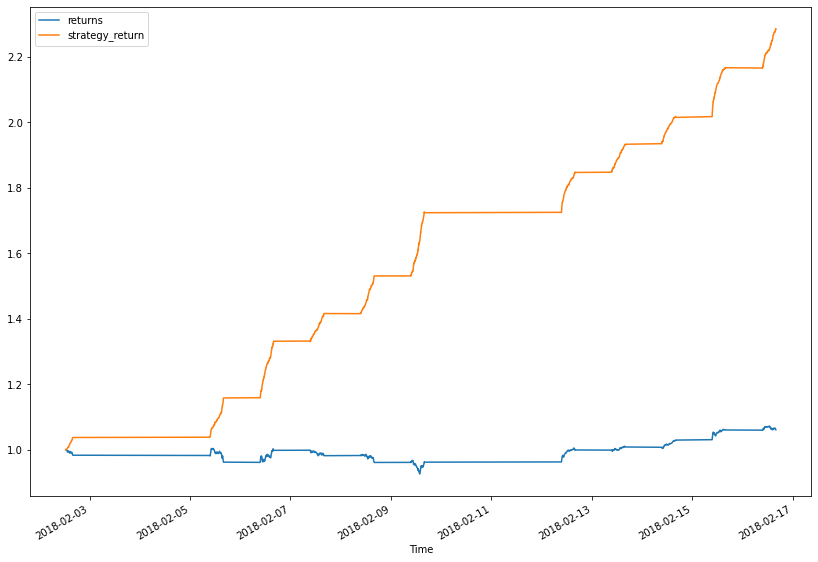

In [ ]:
signals[['returns', 'strategy_return']].cumsum().apply(np.exp).plot(figsize=(14, 10))

### Based on Price

In [ ]:
# Create a new dataframe
close = df['close'].iloc[(-1)*len(predicted_return)-2:-1]
new_df = pd.DataFrame(index=close.index)
new_df['close'] = df['close'][close.index]
pred = pd.DataFrame(np.squeeze(predicted_return), index=close.index[:-1], columns=['next_close'])
new_df = pd.concat([new_df, pred],axis=1)

# Creat buy/sell signals
new_df['signal'] = 0
new_df['signal'].loc[new_df['next_close'] > new_df['close']] = 1
new_df['signal'].loc[new_df['next_close'] < new_df['close']] = -1
# Add market impact
new_df['market_impact'] = df['market_impact'].iloc[(-1)*len(predicted_return)-2:-1]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [322]:
def buy_stock(
    close, # close price column
    signal, # signal column
    market_impact, # market impact column
    initial_money = 10000, # $10000 initial balance
    max_buy = 1, # buy 1 each time
    max_sell = 1, # sell 1 each time
):

    starting_money = initial_money
    states_sell = []
    sell_prices = []
    states_buy = []
    buy_prices = []
    sold = []
    states_money = []
    current_inventory = 0
    
    def buy(i, initial_money, current_inventory):
        shares = initial_money // close[i] # get the shares can afford
        if shares < 1: # cannot afford 1 share
            pass
        else: # else, buy 1
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= (buy_units * close[i] * 1.0004 + market_impact[i])  # update balance
            current_inventory += buy_units # update inventory
            print(
                '%d: buy %d units at price %f, total balance %f, total holding %f'
                % (i, buy_units, round(buy_units * close[i],2), initial_money, current_inventory*close[i])
            )
            states_buy.append(i) # record buys
            buy_prices.append(buy_units * close[i]) # record buy prices
        return initial_money, current_inventory

    def sell(i, initial_money, current_inventory):
        if current_inventory == 0: # do nothing if have 0 share
                    pass
        else: # else, sell 1
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                initial_money += (sell_units * close[i] * 0.9996 - market_impact[i]) # update balance
                current_inventory -= sell_units # update inventory
                print(
                    '%d, sell %d units at price %f, total balance %f, total holding %f'
                    % (i, sell_units, round(sell_units * close[i],2), initial_money, close[i]*current_inventory)
                )
                states_sell.append(i) # record sells
                sell_prices.append(sell_units * close[i]) # record sell prices
        return initial_money, current_inventory
    
    for i in range(close.shape[0]):
        for j in range(len(states_buy)):
          r = (close[i] - buy_prices[j]) / buy_prices[j]
          if (r>0.1) and (states_buy[j] not in sold): # if gain higher than 10%, sell
              if current_inventory > max_sell:
                    sell_units = max_sell
              else:
                    sell_units = current_inventory
              initial_money += (sell_units * close[i] * 0.9996 - market_impact[i])  
              current_inventory -= sell_units
              print(
                    '%d, sell %d inventory at price %f, total balance %f, total holding %f'
                    % (i, sell_units, round(sell_units * close[i],2), initial_money, close[i]*current_inventory)
                )
              sold.append(states_buy[j])

          elif (r<-0.06) and (states_buy[j] not in sold): # if loss higher than 6%, sell
              if current_inventory > max_sell:
                    sell_units = max_sell
              else:
                    sell_units = current_inventory
              initial_money += (sell_units * close[i] * 0.9996 - market_impact[i])
              current_inventory -= sell_units
              print(
                    '%d, sell %d inventory at price %f, total balance %f, total holding %f'
                    % (i, sell_units, round(sell_units * close[i],2), initial_money, close[i]*current_inventory)
                )
              sold.append(states_buy[j])

          elif (states_buy[j]-i == 30) and (states_buy[j] not in sold): # if no signal triggered in 30 minutes, sell
              if current_inventory > max_sell:
                    sell_units = max_sell
              else:
                    sell_units = current_inventory
              initial_money += (sell_units * close[i] * 0.9996 - market_impact[i])
              current_inventory -= sell_units
              print(
                    '%d, sell %d inventory at price %f, total balance %f, total holding %f'
                    % (i, sell_units, round(sell_units * close[i],2), initial_money, close[i]*current_inventory)
                )
              sold.append(states_buy[j])
        
        state = signal[i]
        if state == 1: # buy signal triggered
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )

        elif state == -1: # sell signal triggered
            initial_money, current_inventory = sell(
                i, initial_money, current_inventory
            )
        elif state == 0: # if test period ends, sell all shares
            sell_units = current_inventory
            initial_money += sell_units * close[i] * 0.9996
            current_inventory -= sell_units
            print(
                    '%d, sell all inventory at price %f, total balance %f, total holding %f'
                    % (i, round(close[i],2), initial_money, close[i]*current_inventory)
                )
        states_money.append(initial_money)
      
    # calculate returns and gains
    invest = ((close[-1]*current_inventory + initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, states_money

In [ ]:
# This will show history of trading
states_buy, states_sell, total_gains, invest, states_money = buy_stock(new_df['close'], new_df['signal'], new_df['market_impact'])

In [ ]:
#@title
states_buy, states_sell, total_gains, invest, states_money = buy_stock(new_df['close'], new_df['signal'])

day 0: buy 1 units at price 162.930000, total balance 9837.070007, total holding 162.929993
day 1: buy 1 units at price 162.890000, total balance 9674.180008, total holding 325.779999
day 2: buy 1 units at price 162.920000, total balance 9511.260101, total holding 488.759720
day 3: buy 1 units at price 162.900000, total balance 9348.360107, total holding 651.599976
day 4: buy 1 units at price 162.870000, total balance 9185.490112, total holding 814.349976
day 5: buy 1 units at price 162.910000, total balance 9022.581116, total holding 977.453979
day 6: buy 1 units at price 162.880000, total balance 8859.701111, total holding 1140.160034
day 7: buy 1 units at price 162.880000, total balance 8696.824509, total holding 1303.012817
day 8: buy 1 units at price 162.960000, total balance 8533.864502, total holding 1466.640060
day 9: buy 1 units at price 162.970000, total balance 8370.894501, total holding 1629.700012
day 10: buy 1 units at price 162.990000, total balance 8207.904495, total ho

In [321]:
# Get the return
print(invest)

# Number of buys
print(len(states_buy))

# Number of sells
print(len(states_sell))

1.4215829467773438
350
241


In [ ]:
# Visualize buy/sell signals along with closing price
plt.rcParams["savefig.dpi"]=1000
close = new_df['close'].reset_index()['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='b', lw=2.)
plt.plot(close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title('Total gains %f, Total return %f%%'%(total_gains, invest))
plt.legend()
plt.show()

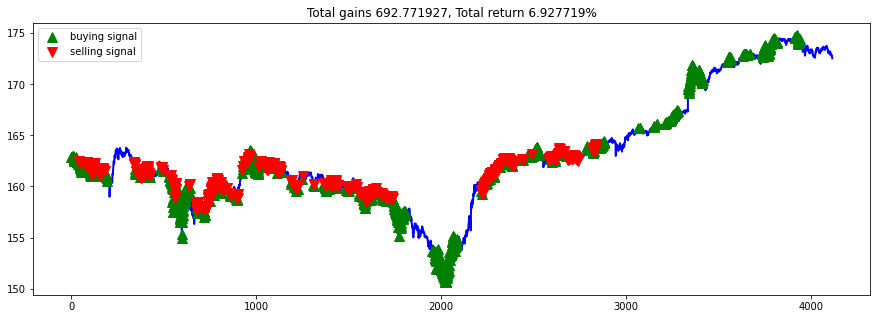

In [ ]:
#@title
plt.rcParams["savefig.dpi"]=1000
close = new_df['close'].reset_index()['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='b', lw=2.)
plt.plot(close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title('Total gains %f, Total return %f%%'%(total_gains, invest))
plt.legend()
plt.show()